# 1: StarDist training

In this notebook we will train the StarDist model on our manually annotated image masks and crops.

***

**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [20]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [22]:
X = sorted(glob(r'images\crops\*.tif'))
Y = sorted(glob(r'masks\crops\*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [23]:
X = list(map(imread,X))
#X = [np.squeeze(x,axis=0) for x in X]
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

Normalize images and fill small label holes.

In [24]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 318.14it/s]


Split into train and validation datasets.

In [25]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 202
- training:       172
- validation:      30


Training data consists of pairs of input image and label instances.

In [26]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

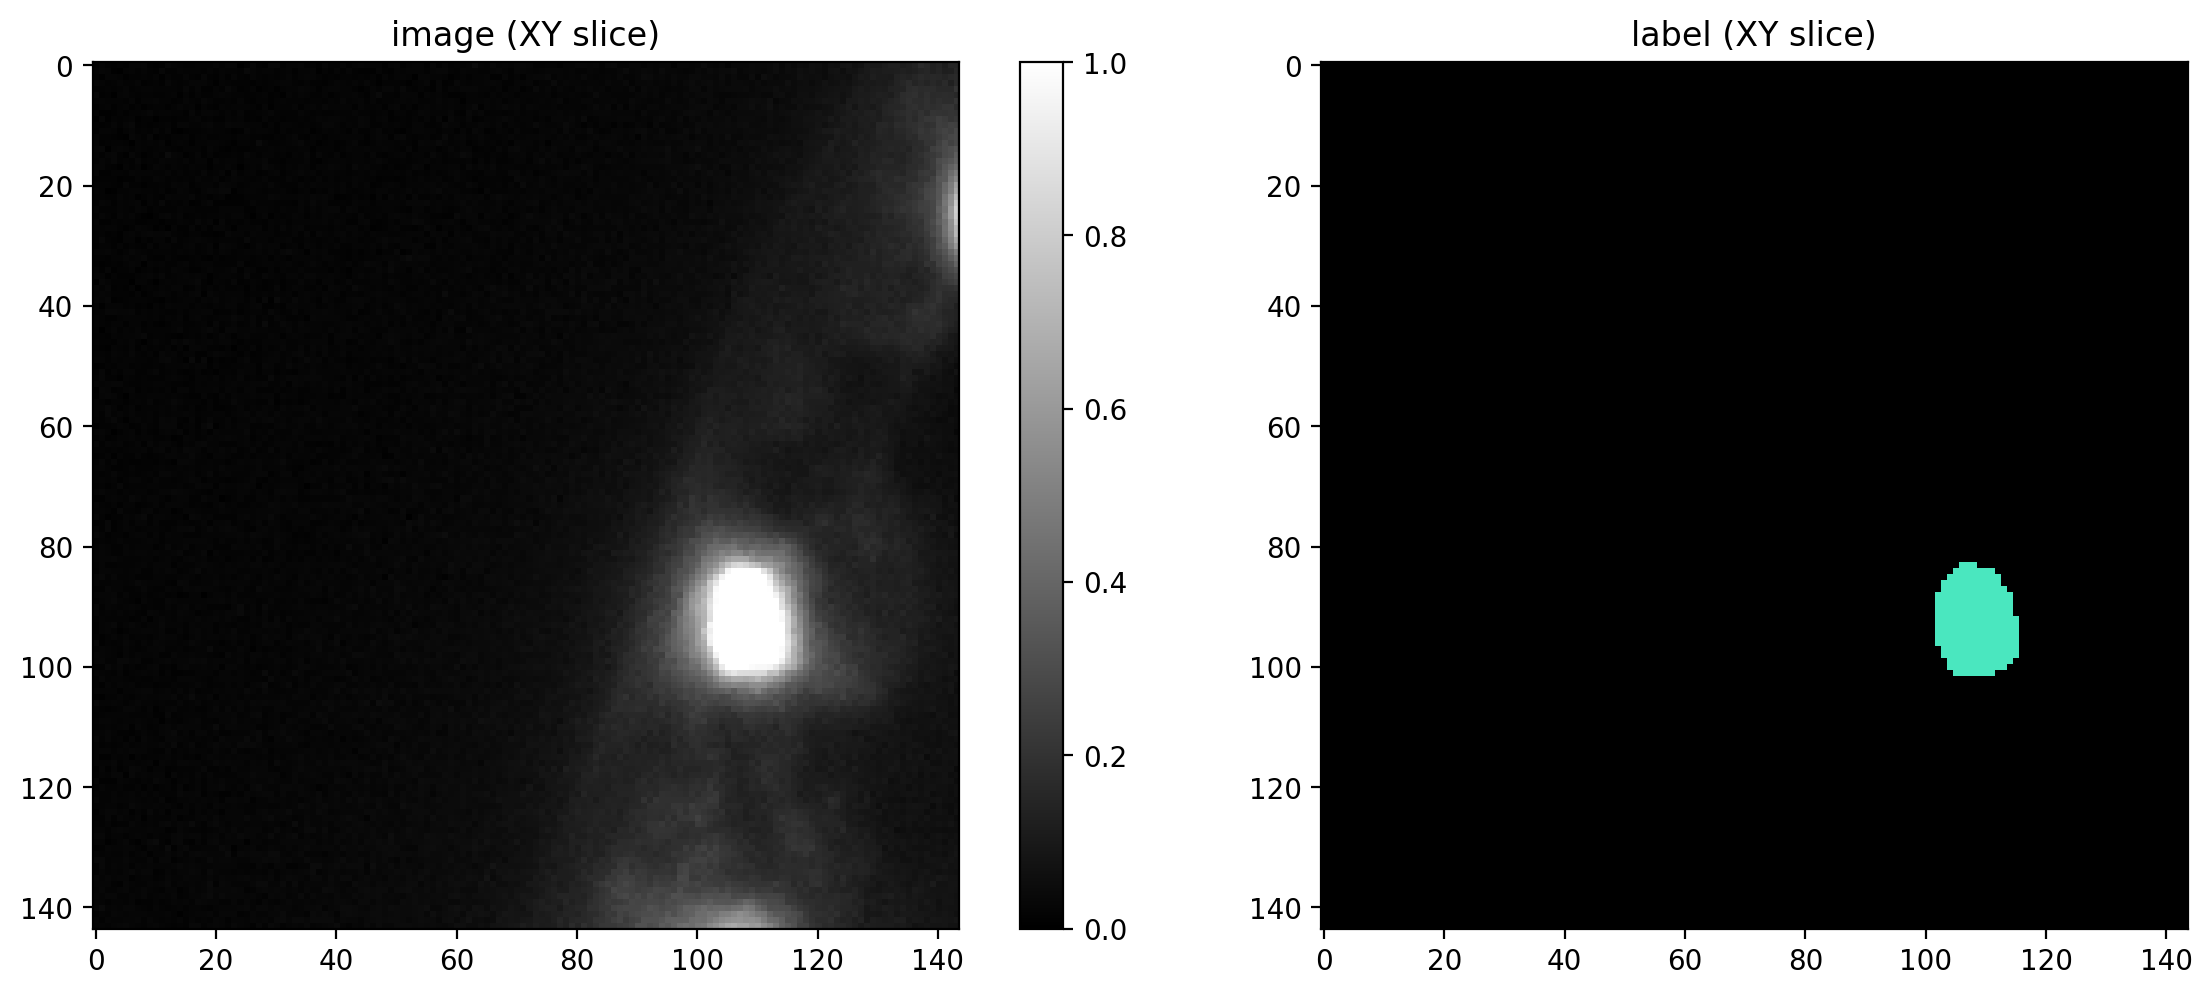

In [27]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [28]:
#print(Config3D.__doc__)

In [29]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (2.5714285714285716, 1.0434782608695652, 1.0)


In [30]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (8,96,96),
    train_batch_size = 2,
)
#print(conf)
#vars(conf)

In [31]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.5, total_memory=8000)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [32]:
model = StarDist3D(conf, name='stardist_gpu', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [33]:
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

1/1 [==============================] - 0s 23ms/step
median object size:      [ 7.   17.25 18.  ]
network field of view :  [26 46 46]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [34]:
def random_fliprot(img, mask, axis=None): 
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)
            
    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(transpose_axis) 
    for ax in axis: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis 
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y

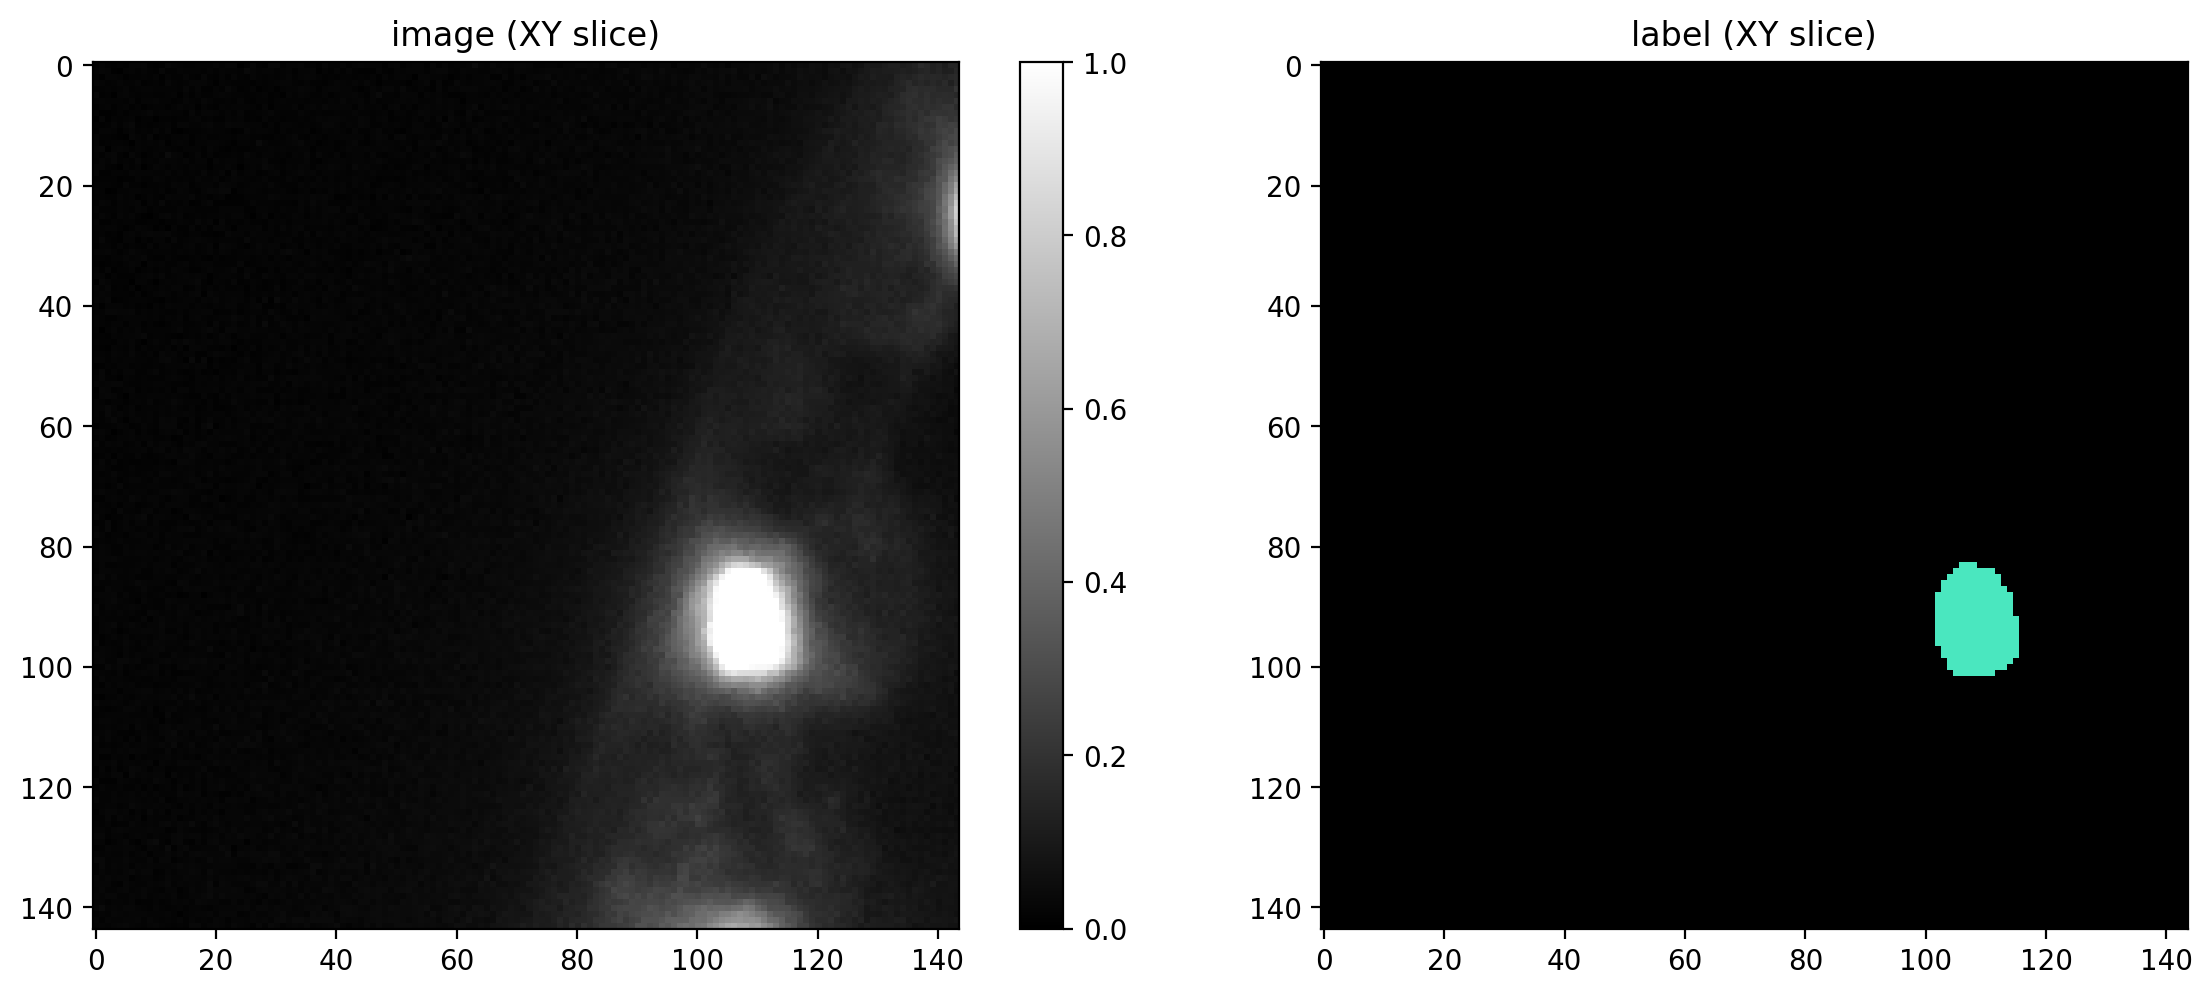

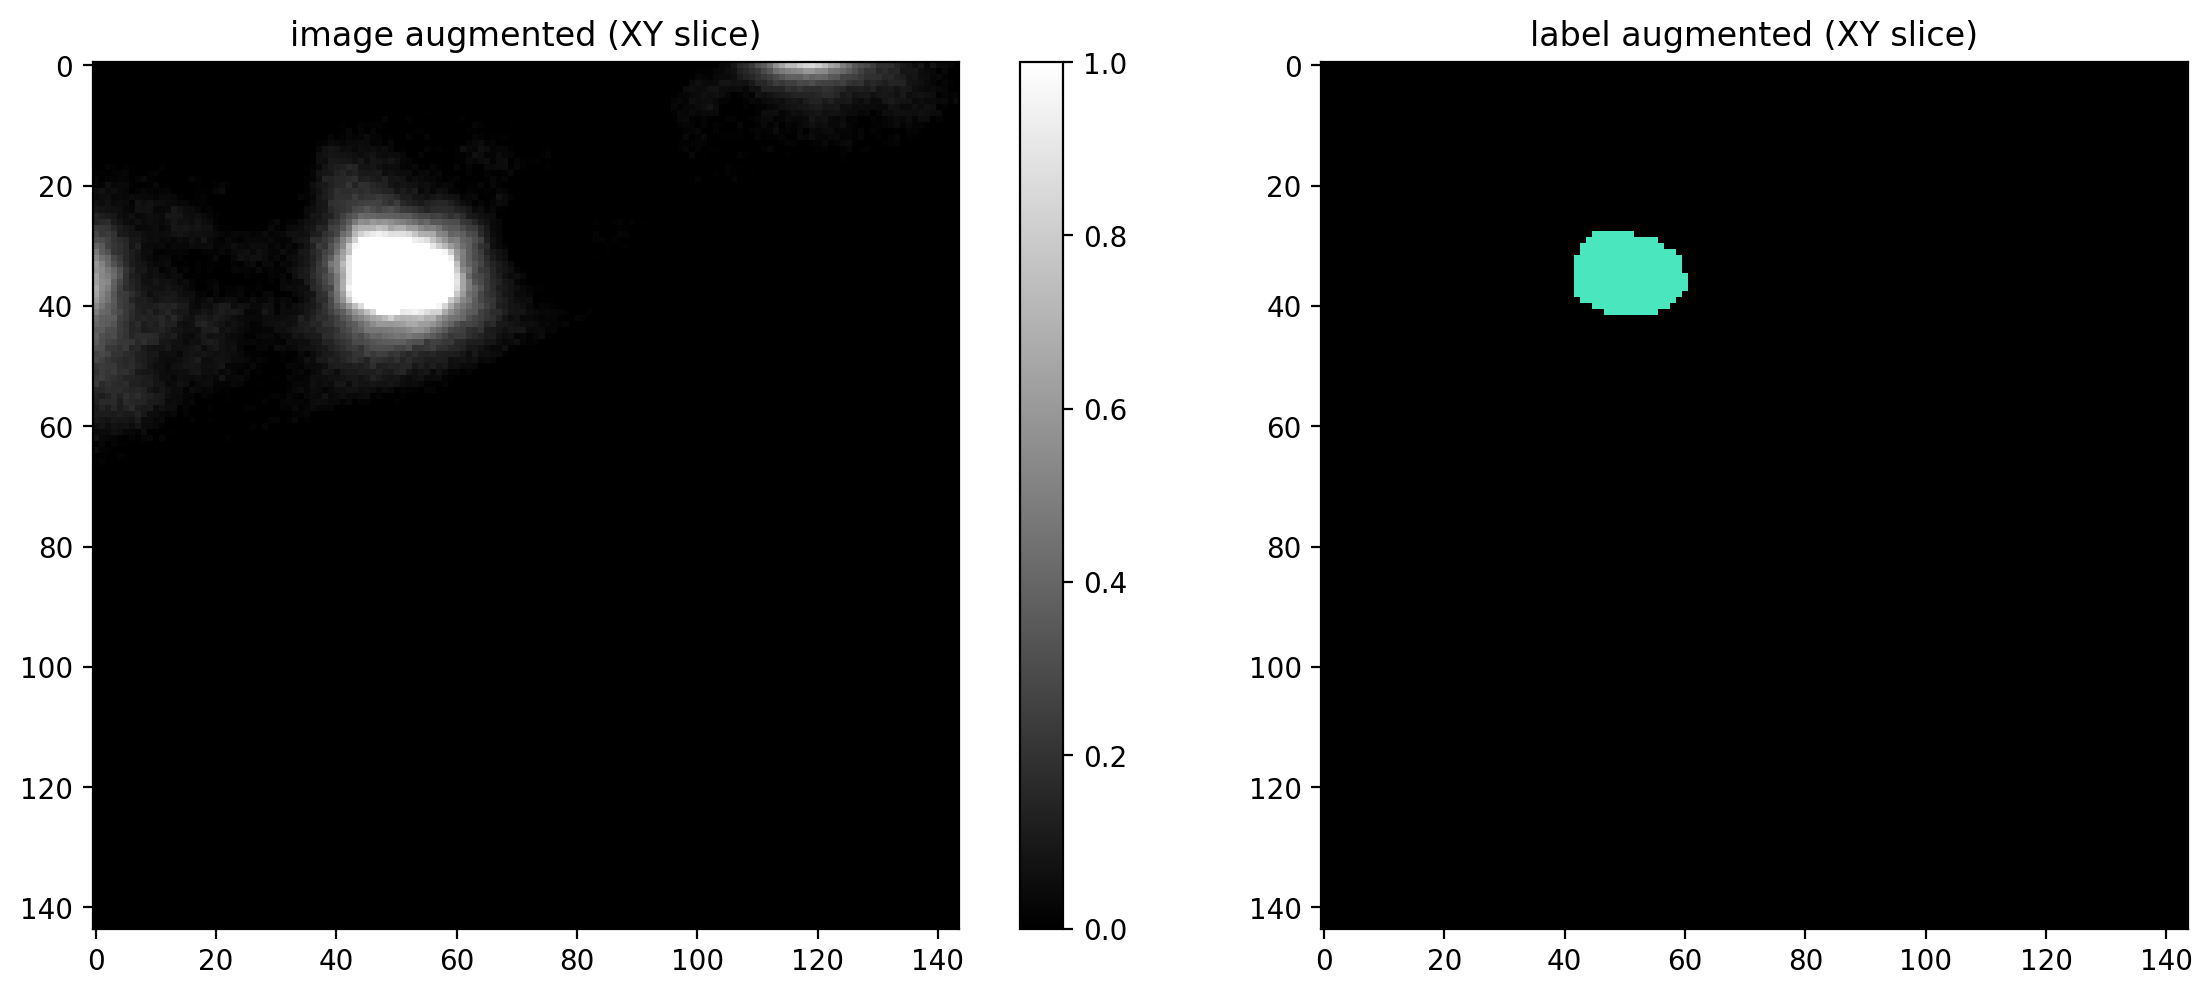

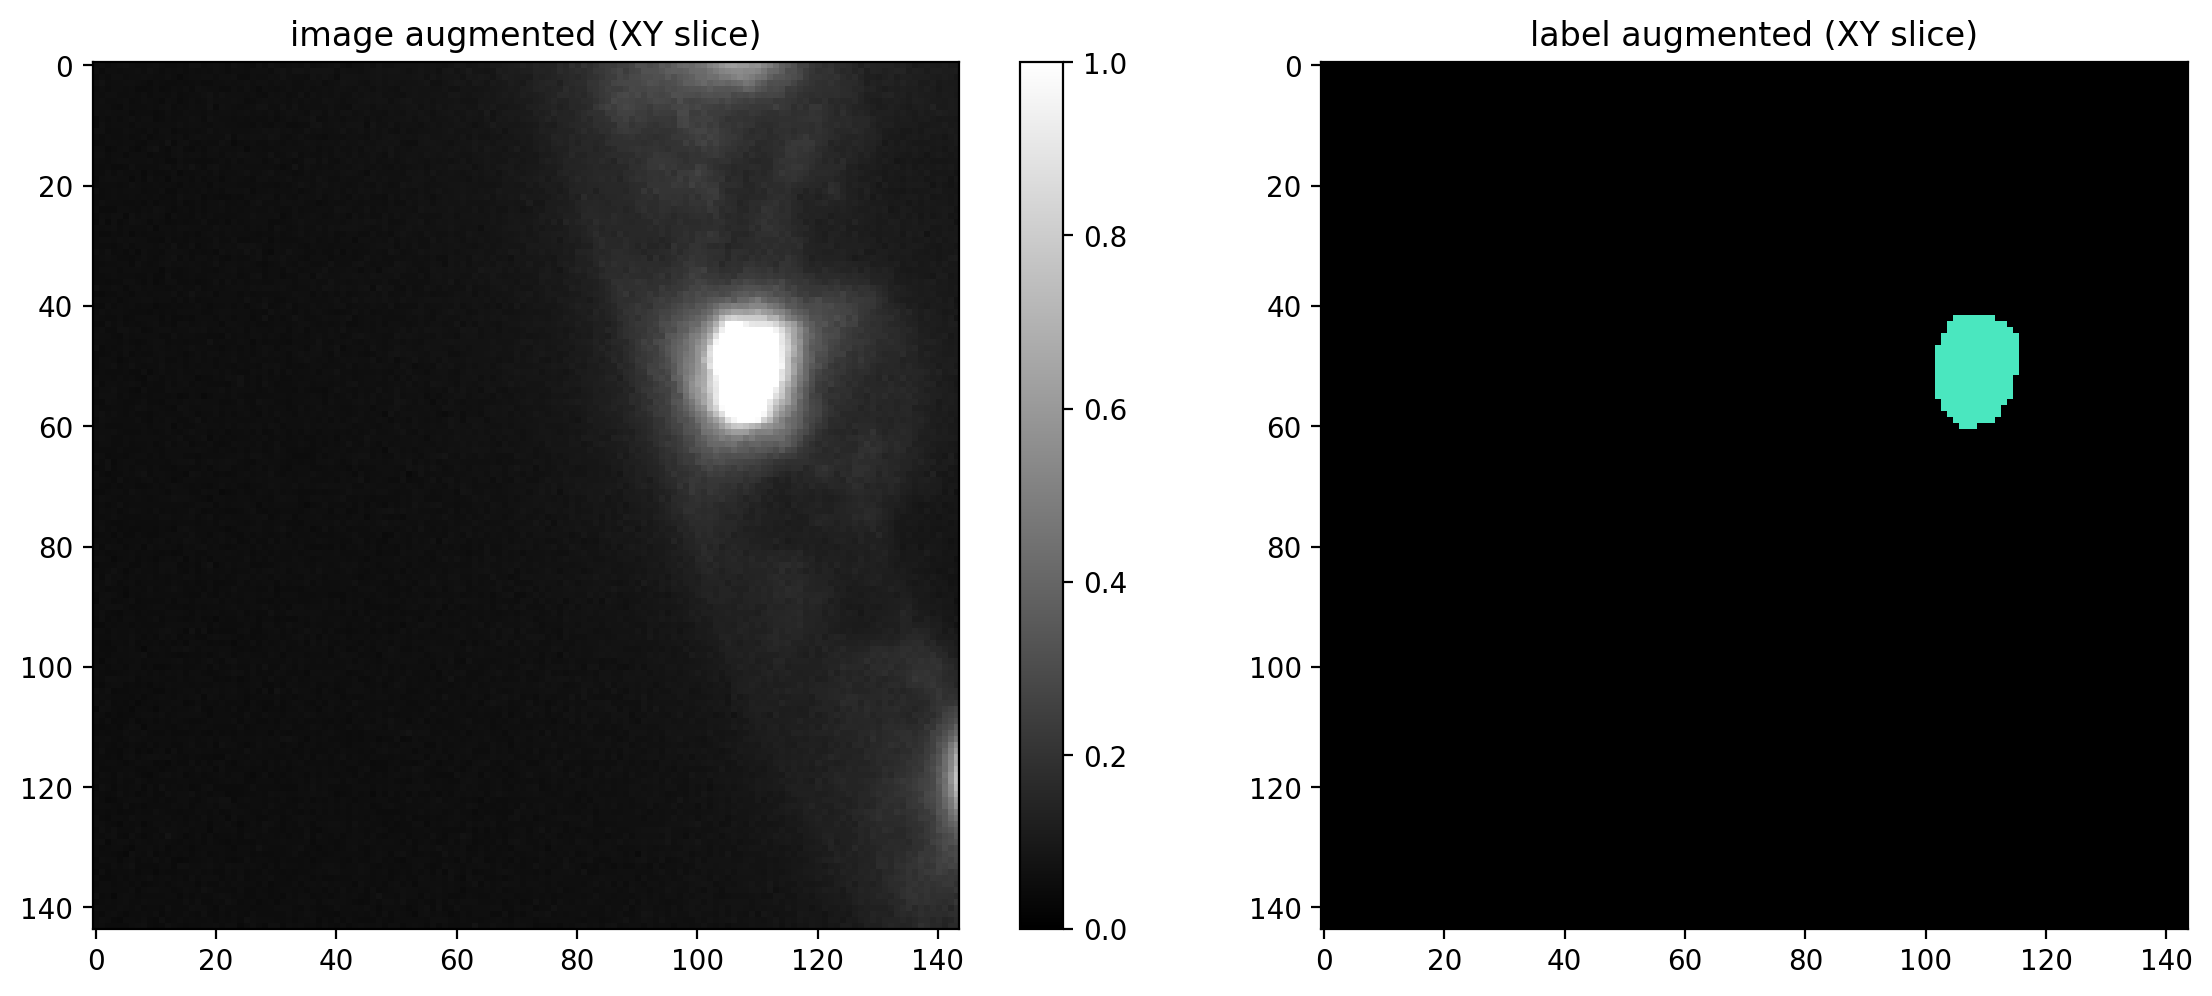

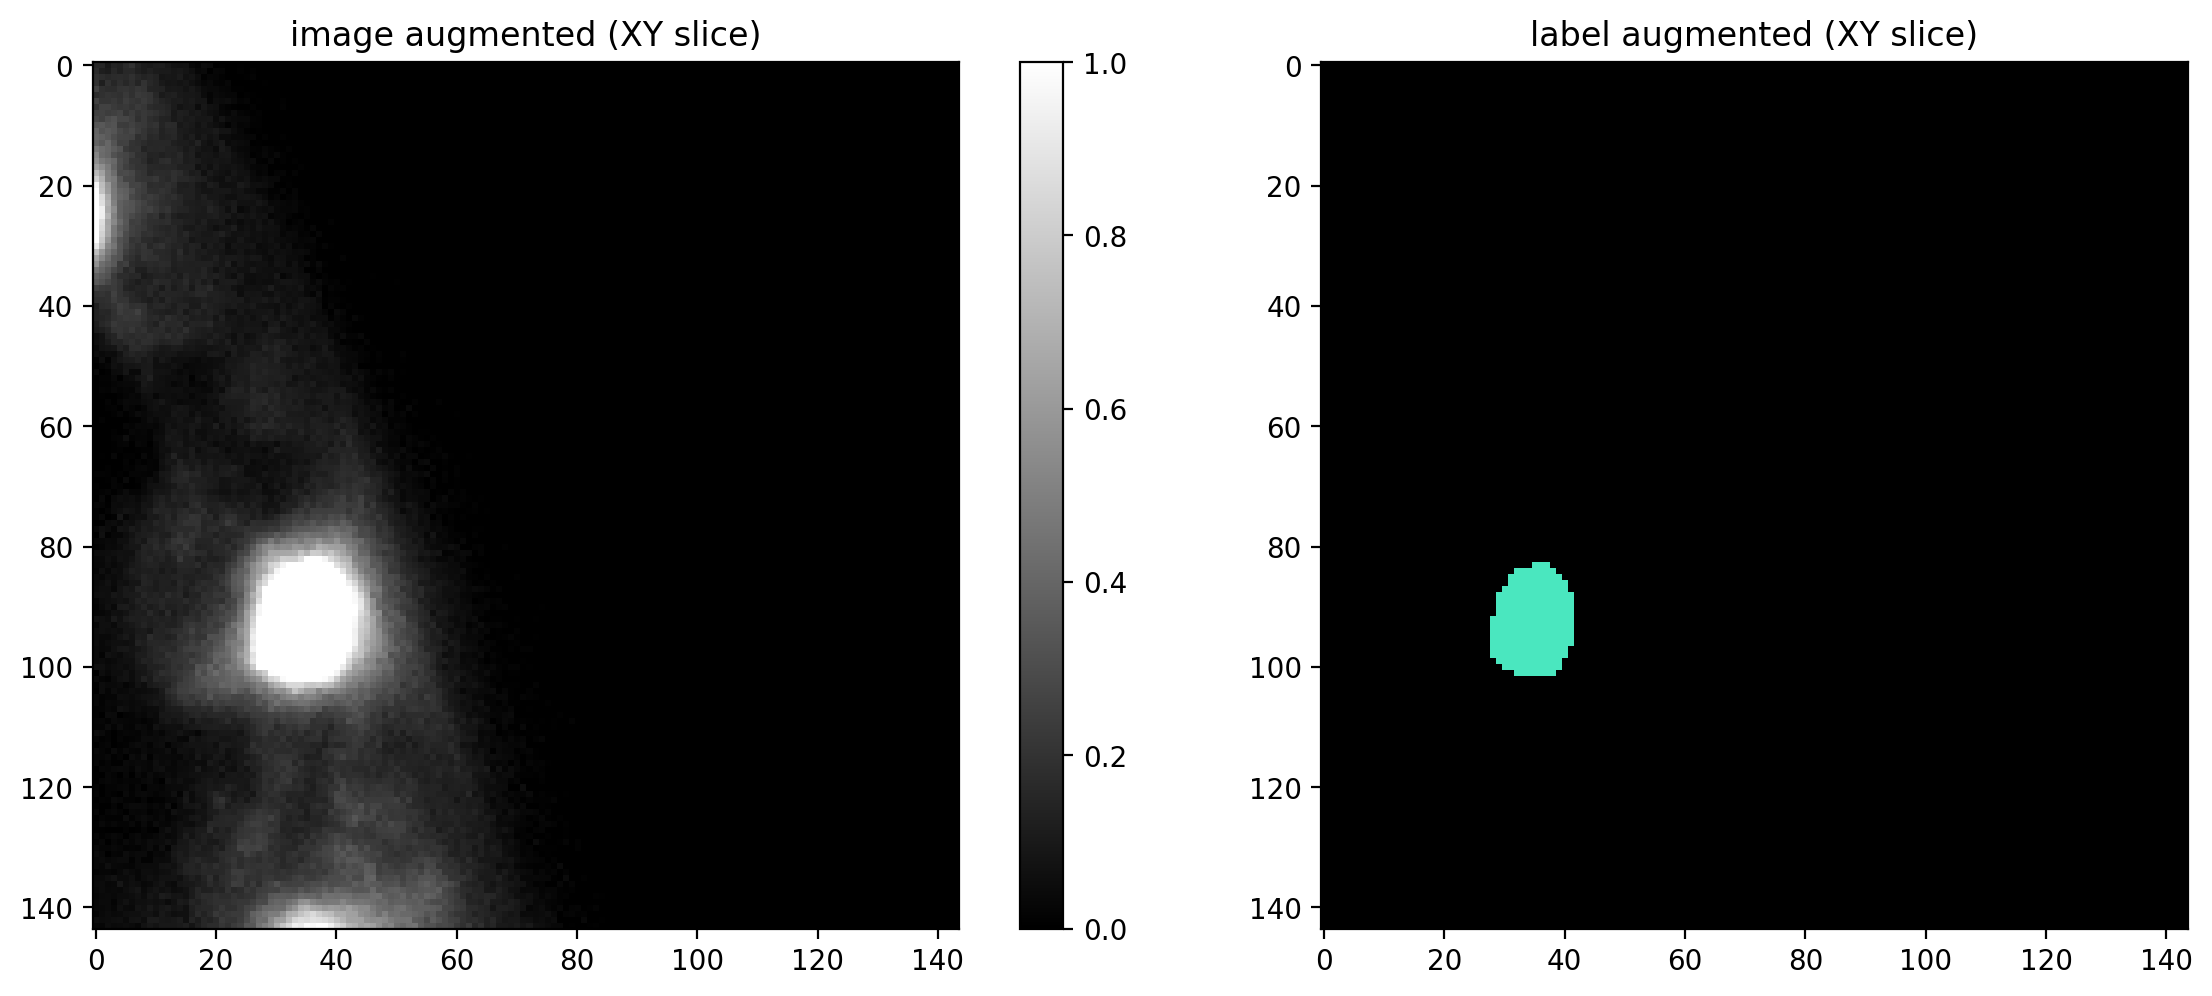

In [35]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [36]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
Epoch 1/400
Cause: Unable to locate the source code of <function _gcd_import at 0x0000022849923490>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x0000022849923490>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x0000022849923490>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 68s 627ms/step - loss: 0.8568 - prob_loss: 0.1307 - dist_loss: 3.6307 - prob_kld: 0.1085 - dist_relevant_mae: 3.6304 - dist_relevant_mse: 25.7328 - dist_dist_iou_metric: 0.1806 - val_loss: 0.5419 - val_prob_loss: 0.0613 - val_dist_loss: 2.4030 - val_prob_kld: 0.0525 - val_dist_relevant_mae: 2.4024 - val_dist_relevant_mse: 10.6649 - val_dist_dist_iou_metric: 0.3913 - lr: 3.0000e-04
Epoch 2/400
100/100 [============================

Epoch 13/400
100/100 [==============================] - 38s 384ms/step - loss: 0.3571 - prob_loss: 0.0214 - dist_loss: 1.6785 - prob_kld: 0.0124 - dist_relevant_mae: 1.6781 - dist_relevant_mse: 6.2800 - dist_dist_iou_metric: 0.4910 - val_loss: 0.3245 - val_prob_loss: 0.0174 - val_dist_loss: 1.5357 - val_prob_kld: 0.0085 - val_dist_relevant_mae: 1.5353 - val_dist_relevant_mse: 4.8723 - val_dist_dist_iou_metric: 0.5286 - lr: 3.0000e-04
Epoch 14/400
100/100 [==============================] - 38s 379ms/step - loss: 0.3605 - prob_loss: 0.0227 - dist_loss: 1.6892 - prob_kld: 0.0130 - dist_relevant_mae: 1.6888 - dist_relevant_mse: 6.4652 - dist_dist_iou_metric: 0.4996 - val_loss: 0.3215 - val_prob_loss: 0.0194 - val_dist_loss: 1.5106 - val_prob_kld: 0.0106 - val_dist_relevant_mae: 1.5102 - val_dist_relevant_mse: 4.7334 - val_dist_dist_iou_metric: 0.5345 - lr: 3.0000e-04
Epoch 15/400
100/100 [==============================] - 37s 374ms/step - loss: 0.3705 - prob_loss: 0.0235 - dist_loss: 1.735

Epoch 26/400
100/100 [==============================] - 29s 290ms/step - loss: 0.3212 - prob_loss: 0.0205 - dist_loss: 1.5032 - prob_kld: 0.0106 - dist_relevant_mae: 1.5028 - dist_relevant_mse: 5.3260 - dist_dist_iou_metric: 0.5575 - val_loss: 0.2729 - val_prob_loss: 0.0144 - val_dist_loss: 1.2926 - val_prob_kld: 0.0056 - val_dist_relevant_mae: 1.2923 - val_dist_relevant_mse: 3.5779 - val_dist_dist_iou_metric: 0.5740 - lr: 3.0000e-04
Epoch 27/400
100/100 [==============================] - 28s 283ms/step - loss: 0.3277 - prob_loss: 0.0222 - dist_loss: 1.5274 - prob_kld: 0.0112 - dist_relevant_mae: 1.5270 - dist_relevant_mse: 5.3789 - dist_dist_iou_metric: 0.5589 - val_loss: 0.2867 - val_prob_loss: 0.0179 - val_dist_loss: 1.3442 - val_prob_kld: 0.0090 - val_dist_relevant_mae: 1.3438 - val_dist_relevant_mse: 3.8371 - val_dist_dist_iou_metric: 0.5844 - lr: 3.0000e-04
Epoch 28/400
100/100 [==============================] - 28s 286ms/step - loss: 0.3228 - prob_loss: 0.0182 - dist_loss: 1.522

Epoch 39/400
100/100 [==============================] - 32s 324ms/step - loss: 0.3056 - prob_loss: 0.0190 - dist_loss: 1.4333 - prob_kld: 0.0092 - dist_relevant_mae: 1.4329 - dist_relevant_mse: 4.8226 - dist_dist_iou_metric: 0.5688 - val_loss: 0.2644 - val_prob_loss: 0.0148 - val_dist_loss: 1.2478 - val_prob_kld: 0.0060 - val_dist_relevant_mae: 1.2474 - val_dist_relevant_mse: 3.4224 - val_dist_dist_iou_metric: 0.5859 - lr: 3.0000e-04
Epoch 40/400
100/100 [==============================] - 32s 322ms/step - loss: 0.3107 - prob_loss: 0.0201 - dist_loss: 1.4527 - prob_kld: 0.0106 - dist_relevant_mae: 1.4523 - dist_relevant_mse: 5.1079 - dist_dist_iou_metric: 0.5725 - val_loss: 0.2532 - val_prob_loss: 0.0149 - val_dist_loss: 1.1916 - val_prob_kld: 0.0060 - val_dist_relevant_mae: 1.1912 - val_dist_relevant_mse: 3.1314 - val_dist_dist_iou_metric: 0.6173 - lr: 3.0000e-04
Epoch 41/400
100/100 [==============================] - 34s 348ms/step - loss: 0.3138 - prob_loss: 0.0216 - dist_loss: 1.460

Epoch 52/400
100/100 [==============================] - 30s 304ms/step - loss: 0.2945 - prob_loss: 0.0178 - dist_loss: 1.3837 - prob_kld: 0.0083 - dist_relevant_mae: 1.3833 - dist_relevant_mse: 4.6427 - dist_dist_iou_metric: 0.5902 - val_loss: 0.2549 - val_prob_loss: 0.0144 - val_dist_loss: 1.2029 - val_prob_kld: 0.0055 - val_dist_relevant_mae: 1.2024 - val_dist_relevant_mse: 3.1043 - val_dist_dist_iou_metric: 0.6269 - lr: 3.0000e-04
Epoch 53/400
100/100 [==============================] - 30s 301ms/step - loss: 0.3054 - prob_loss: 0.0211 - dist_loss: 1.4214 - prob_kld: 0.0095 - dist_relevant_mae: 1.4210 - dist_relevant_mse: 4.7062 - dist_dist_iou_metric: 0.5937 - val_loss: 0.2436 - val_prob_loss: 0.0147 - val_dist_loss: 1.1445 - val_prob_kld: 0.0058 - val_dist_relevant_mae: 1.1442 - val_dist_relevant_mse: 2.9584 - val_dist_dist_iou_metric: 0.6314 - lr: 3.0000e-04
Epoch 54/400
100/100 [==============================] - 32s 319ms/step - loss: 0.2889 - prob_loss: 0.0182 - dist_loss: 1.353

Epoch 65/400
100/100 [==============================] - 35s 352ms/step - loss: 0.3037 - prob_loss: 0.0207 - dist_loss: 1.4149 - prob_kld: 0.0098 - dist_relevant_mae: 1.4145 - dist_relevant_mse: 4.9464 - dist_dist_iou_metric: 0.5863 - val_loss: 0.2672 - val_prob_loss: 0.0149 - val_dist_loss: 1.2614 - val_prob_kld: 0.0060 - val_dist_relevant_mae: 1.2610 - val_dist_relevant_mse: 3.3144 - val_dist_dist_iou_metric: 0.5900 - lr: 3.0000e-04
Epoch 66/400
100/100 [==============================] - 35s 357ms/step - loss: 0.2858 - prob_loss: 0.0181 - dist_loss: 1.3387 - prob_kld: 0.0088 - dist_relevant_mae: 1.3383 - dist_relevant_mse: 4.2937 - dist_dist_iou_metric: 0.5945 - val_loss: 0.2396 - val_prob_loss: 0.0138 - val_dist_loss: 1.1292 - val_prob_kld: 0.0050 - val_dist_relevant_mae: 1.1288 - val_dist_relevant_mse: 2.8652 - val_dist_dist_iou_metric: 0.6423 - lr: 3.0000e-04
Epoch 67/400
100/100 [==============================] - 32s 321ms/step - loss: 0.2859 - prob_loss: 0.0169 - dist_loss: 1.345

Epoch 78/400
100/100 [==============================] - 34s 338ms/step - loss: 0.2810 - prob_loss: 0.0193 - dist_loss: 1.3083 - prob_kld: 0.0086 - dist_relevant_mae: 1.3079 - dist_relevant_mse: 4.2080 - dist_dist_iou_metric: 0.6050 - val_loss: 0.2295 - val_prob_loss: 0.0138 - val_dist_loss: 1.0787 - val_prob_kld: 0.0049 - val_dist_relevant_mae: 1.0783 - val_dist_relevant_mse: 2.6322 - val_dist_dist_iou_metric: 0.6550 - lr: 3.0000e-04
Epoch 79/400
100/100 [==============================] - 33s 331ms/step - loss: 0.2861 - prob_loss: 0.0179 - dist_loss: 1.3410 - prob_kld: 0.0076 - dist_relevant_mae: 1.3406 - dist_relevant_mse: 4.6781 - dist_dist_iou_metric: 0.6116 - val_loss: 0.2368 - val_prob_loss: 0.0142 - val_dist_loss: 1.1133 - val_prob_kld: 0.0053 - val_dist_relevant_mae: 1.1129 - val_dist_relevant_mse: 2.8530 - val_dist_dist_iou_metric: 0.6415 - lr: 3.0000e-04
Epoch 80/400
100/100 [==============================] - 32s 326ms/step - loss: 0.3002 - prob_loss: 0.0200 - dist_loss: 1.400

Epoch 91/400
100/100 [==============================] - 35s 349ms/step - loss: 0.2924 - prob_loss: 0.0203 - dist_loss: 1.3603 - prob_kld: 0.0088 - dist_relevant_mae: 1.3599 - dist_relevant_mse: 4.7663 - dist_dist_iou_metric: 0.5947 - val_loss: 0.2312 - val_prob_loss: 0.0139 - val_dist_loss: 1.0866 - val_prob_kld: 0.0050 - val_dist_relevant_mae: 1.0862 - val_dist_relevant_mse: 2.6859 - val_dist_dist_iou_metric: 0.6349 - lr: 3.0000e-04
Epoch 92/400
100/100 [==============================] - 35s 351ms/step - loss: 0.2875 - prob_loss: 0.0178 - dist_loss: 1.3484 - prob_kld: 0.0082 - dist_relevant_mae: 1.3481 - dist_relevant_mse: 4.6325 - dist_dist_iou_metric: 0.5946 - val_loss: 0.2358 - val_prob_loss: 0.0143 - val_dist_loss: 1.1073 - val_prob_kld: 0.0055 - val_dist_relevant_mae: 1.1069 - val_dist_relevant_mse: 2.8348 - val_dist_dist_iou_metric: 0.6498 - lr: 3.0000e-04
Epoch 93/400
100/100 [==============================] - 38s 380ms/step - loss: 0.2844 - prob_loss: 0.0192 - dist_loss: 1.326

Epoch 104/400
100/100 [==============================] - 38s 386ms/step - loss: 0.2753 - prob_loss: 0.0178 - dist_loss: 1.2877 - prob_kld: 0.0079 - dist_relevant_mae: 1.2874 - dist_relevant_mse: 4.0345 - dist_dist_iou_metric: 0.6089 - val_loss: 0.2323 - val_prob_loss: 0.0145 - val_dist_loss: 1.0890 - val_prob_kld: 0.0057 - val_dist_relevant_mae: 1.0886 - val_dist_relevant_mse: 2.6416 - val_dist_dist_iou_metric: 0.6466 - lr: 3.0000e-04
Epoch 105/400
100/100 [==============================] - 36s 361ms/step - loss: 0.2781 - prob_loss: 0.0181 - dist_loss: 1.3001 - prob_kld: 0.0074 - dist_relevant_mae: 1.2998 - dist_relevant_mse: 4.1416 - dist_dist_iou_metric: 0.6199 - val_loss: 0.2299 - val_prob_loss: 0.0147 - val_dist_loss: 1.0760 - val_prob_kld: 0.0058 - val_dist_relevant_mae: 1.0757 - val_dist_relevant_mse: 2.5948 - val_dist_dist_iou_metric: 0.6443 - lr: 3.0000e-04
Epoch 106/400
100/100 [==============================] - 37s 371ms/step - loss: 0.2778 - prob_loss: 0.0187 - dist_loss: 1.

Epoch 117/400
100/100 [==============================] - 41s 411ms/step - loss: 0.2694 - prob_loss: 0.0166 - dist_loss: 1.2641 - prob_kld: 0.0078 - dist_relevant_mae: 1.2637 - dist_relevant_mse: 4.0261 - dist_dist_iou_metric: 0.6059 - val_loss: 0.2233 - val_prob_loss: 0.0142 - val_dist_loss: 1.0459 - val_prob_kld: 0.0053 - val_dist_relevant_mae: 1.0455 - val_dist_relevant_mse: 2.5057 - val_dist_dist_iou_metric: 0.6569 - lr: 3.0000e-04
Epoch 118/400
100/100 [==============================] - 40s 407ms/step - loss: 0.2616 - prob_loss: 0.0168 - dist_loss: 1.2239 - prob_kld: 0.0073 - dist_relevant_mae: 1.2235 - dist_relevant_mse: 3.8022 - dist_dist_iou_metric: 0.6277 - val_loss: 0.2231 - val_prob_loss: 0.0139 - val_dist_loss: 1.0459 - val_prob_kld: 0.0051 - val_dist_relevant_mae: 1.0455 - val_dist_relevant_mse: 2.5424 - val_dist_dist_iou_metric: 0.6630 - lr: 3.0000e-04
Epoch 119/400
100/100 [==============================] - 42s 422ms/step - loss: 0.2773 - prob_loss: 0.0195 - dist_loss: 1.

Epoch 130/400
100/100 [==============================] - 39s 394ms/step - loss: 0.2877 - prob_loss: 0.0198 - dist_loss: 1.3396 - prob_kld: 0.0085 - dist_relevant_mae: 1.3392 - dist_relevant_mse: 4.5286 - dist_dist_iou_metric: 0.6244 - val_loss: 0.2313 - val_prob_loss: 0.0139 - val_dist_loss: 1.0868 - val_prob_kld: 0.0051 - val_dist_relevant_mae: 1.0865 - val_dist_relevant_mse: 2.6955 - val_dist_dist_iou_metric: 0.6294 - lr: 3.0000e-04
Epoch 131/400
100/100 [==============================] - 38s 388ms/step - loss: 0.2785 - prob_loss: 0.0182 - dist_loss: 1.3014 - prob_kld: 0.0078 - dist_relevant_mae: 1.3010 - dist_relevant_mse: 4.5999 - dist_dist_iou_metric: 0.6098 - val_loss: 0.2244 - val_prob_loss: 0.0139 - val_dist_loss: 1.0522 - val_prob_kld: 0.0051 - val_dist_relevant_mae: 1.0518 - val_dist_relevant_mse: 2.5881 - val_dist_dist_iou_metric: 0.6586 - lr: 3.0000e-04
Epoch 132/400
100/100 [==============================] - 41s 414ms/step - loss: 0.2752 - prob_loss: 0.0171 - dist_loss: 1.

Epoch 143/400
100/100 [==============================] - 40s 408ms/step - loss: 0.2613 - prob_loss: 0.0191 - dist_loss: 1.2111 - prob_kld: 0.0082 - dist_relevant_mae: 1.2108 - dist_relevant_mse: 3.7910 - dist_dist_iou_metric: 0.6234 - val_loss: 0.2109 - val_prob_loss: 0.0135 - val_dist_loss: 0.9871 - val_prob_kld: 0.0046 - val_dist_relevant_mae: 0.9868 - val_dist_relevant_mse: 2.3086 - val_dist_dist_iou_metric: 0.6725 - lr: 3.0000e-04
Epoch 144/400
100/100 [==============================] - 39s 398ms/step - loss: 0.2908 - prob_loss: 0.0196 - dist_loss: 1.3561 - prob_kld: 0.0086 - dist_relevant_mae: 1.3557 - dist_relevant_mse: 5.2559 - dist_dist_iou_metric: 0.6160 - val_loss: 0.2172 - val_prob_loss: 0.0135 - val_dist_loss: 1.0184 - val_prob_kld: 0.0047 - val_dist_relevant_mae: 1.0180 - val_dist_relevant_mse: 2.4361 - val_dist_dist_iou_metric: 0.6691 - lr: 3.0000e-04
Epoch 145/400
100/100 [==============================] - 43s 430ms/step - loss: 0.2607 - prob_loss: 0.0174 - dist_loss: 1.

Epoch 156/400
100/100 [==============================] - 44s 440ms/step - loss: 0.2789 - prob_loss: 0.0183 - dist_loss: 1.3030 - prob_kld: 0.0075 - dist_relevant_mae: 1.3026 - dist_relevant_mse: 4.4203 - dist_dist_iou_metric: 0.6177 - val_loss: 0.2111 - val_prob_loss: 0.0135 - val_dist_loss: 0.9879 - val_prob_kld: 0.0047 - val_dist_relevant_mae: 0.9875 - val_dist_relevant_mse: 2.3607 - val_dist_dist_iou_metric: 0.6766 - lr: 3.0000e-04
Epoch 157/400
100/100 [==============================] - 44s 441ms/step - loss: 0.2564 - prob_loss: 0.0180 - dist_loss: 1.1921 - prob_kld: 0.0073 - dist_relevant_mae: 1.1917 - dist_relevant_mse: 3.7728 - dist_dist_iou_metric: 0.6383 - val_loss: 0.2089 - val_prob_loss: 0.0136 - val_dist_loss: 0.9764 - val_prob_kld: 0.0048 - val_dist_relevant_mae: 0.9760 - val_dist_relevant_mse: 2.3040 - val_dist_dist_iou_metric: 0.6801 - lr: 3.0000e-04
Epoch 158/400
100/100 [==============================] - 39s 394ms/step - loss: 0.2502 - prob_loss: 0.0173 - dist_loss: 1.

Epoch 169/400
100/100 [==============================] - 44s 447ms/step - loss: 0.2555 - prob_loss: 0.0157 - dist_loss: 1.1993 - prob_kld: 0.0065 - dist_relevant_mae: 1.1989 - dist_relevant_mse: 3.7537 - dist_dist_iou_metric: 0.6272 - val_loss: 0.2149 - val_prob_loss: 0.0132 - val_dist_loss: 1.0084 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 1.0080 - val_dist_relevant_mse: 2.3935 - val_dist_dist_iou_metric: 0.6698 - lr: 3.0000e-04
Epoch 170/400
100/100 [==============================] - 43s 432ms/step - loss: 0.2761 - prob_loss: 0.0191 - dist_loss: 1.2853 - prob_kld: 0.0082 - dist_relevant_mae: 1.2849 - dist_relevant_mse: 4.8129 - dist_dist_iou_metric: 0.6283 - val_loss: 0.2204 - val_prob_loss: 0.0134 - val_dist_loss: 1.0352 - val_prob_kld: 0.0046 - val_dist_relevant_mae: 1.0348 - val_dist_relevant_mse: 2.5185 - val_dist_dist_iou_metric: 0.6687 - lr: 3.0000e-04
Epoch 171/400
100/100 [==============================] - 47s 479ms/step - loss: 0.2547 - prob_loss: 0.0155 - dist_loss: 1.

Epoch 182/400
100/100 [==============================] - 43s 435ms/step - loss: 0.2539 - prob_loss: 0.0190 - dist_loss: 1.1749 - prob_kld: 0.0077 - dist_relevant_mae: 1.1745 - dist_relevant_mse: 3.5843 - dist_dist_iou_metric: 0.6391 - val_loss: 0.2115 - val_prob_loss: 0.0135 - val_dist_loss: 0.9900 - val_prob_kld: 0.0047 - val_dist_relevant_mae: 0.9896 - val_dist_relevant_mse: 2.3250 - val_dist_dist_iou_metric: 0.6782 - lr: 3.0000e-04
Epoch 183/400
100/100 [==============================] - 53s 529ms/step - loss: 0.2670 - prob_loss: 0.0187 - dist_loss: 1.2414 - prob_kld: 0.0084 - dist_relevant_mae: 1.2410 - dist_relevant_mse: 4.1547 - dist_dist_iou_metric: 0.6206 - val_loss: 0.2341 - val_prob_loss: 0.0138 - val_dist_loss: 1.1017 - val_prob_kld: 0.0050 - val_dist_relevant_mae: 1.1013 - val_dist_relevant_mse: 2.7616 - val_dist_dist_iou_metric: 0.6282 - lr: 3.0000e-04
Epoch 184/400
100/100 [==============================] - 45s 459ms/step - loss: 0.2535 - prob_loss: 0.0164 - dist_loss: 1.

Epoch 195/400
100/100 [==============================] - 45s 459ms/step - loss: 0.2641 - prob_loss: 0.0188 - dist_loss: 1.2265 - prob_kld: 0.0076 - dist_relevant_mae: 1.2261 - dist_relevant_mse: 4.0991 - dist_dist_iou_metric: 0.6488 - val_loss: 0.2075 - val_prob_loss: 0.0133 - val_dist_loss: 0.9715 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9711 - val_dist_relevant_mse: 2.2507 - val_dist_dist_iou_metric: 0.6849 - lr: 3.0000e-04
Epoch 196/400
100/100 [==============================] - 47s 476ms/step - loss: 0.2659 - prob_loss: 0.0166 - dist_loss: 1.2464 - prob_kld: 0.0069 - dist_relevant_mae: 1.2460 - dist_relevant_mse: 3.9034 - dist_dist_iou_metric: 0.6435 - val_loss: 0.2187 - val_prob_loss: 0.0138 - val_dist_loss: 1.0244 - val_prob_kld: 0.0050 - val_dist_relevant_mae: 1.0240 - val_dist_relevant_mse: 2.5058 - val_dist_dist_iou_metric: 0.6582 - lr: 3.0000e-04
Epoch 197/400
100/100 [==============================] - 46s 468ms/step - loss: 0.2583 - prob_loss: 0.0183 - dist_loss: 1.

Epoch 208/400
100/100 [==============================] - 54s 544ms/step - loss: 0.2770 - prob_loss: 0.0203 - dist_loss: 1.2836 - prob_kld: 0.0085 - dist_relevant_mae: 1.2833 - dist_relevant_mse: 4.2539 - dist_dist_iou_metric: 0.6340 - val_loss: 0.2139 - val_prob_loss: 0.0136 - val_dist_loss: 1.0013 - val_prob_kld: 0.0048 - val_dist_relevant_mae: 1.0010 - val_dist_relevant_mse: 2.3436 - val_dist_dist_iou_metric: 0.6719 - lr: 3.0000e-04
Epoch 209/400
100/100 [==============================] - 57s 575ms/step - loss: 0.2636 - prob_loss: 0.0170 - dist_loss: 1.2328 - prob_kld: 0.0068 - dist_relevant_mae: 1.2325 - dist_relevant_mse: 4.1715 - dist_dist_iou_metric: 0.6323 - val_loss: 0.2130 - val_prob_loss: 0.0139 - val_dist_loss: 0.9952 - val_prob_kld: 0.0051 - val_dist_relevant_mae: 0.9949 - val_dist_relevant_mse: 2.3203 - val_dist_dist_iou_metric: 0.6740 - lr: 3.0000e-04
Epoch 210/400
100/100 [==============================] - 53s 533ms/step - loss: 0.2608 - prob_loss: 0.0189 - dist_loss: 1.

Epoch 221/400
100/100 [==============================] - 53s 539ms/step - loss: 0.2687 - prob_loss: 0.0169 - dist_loss: 1.2588 - prob_kld: 0.0069 - dist_relevant_mae: 1.2584 - dist_relevant_mse: 4.2930 - dist_dist_iou_metric: 0.6421 - val_loss: 0.2142 - val_prob_loss: 0.0137 - val_dist_loss: 1.0023 - val_prob_kld: 0.0049 - val_dist_relevant_mae: 1.0020 - val_dist_relevant_mse: 2.4313 - val_dist_dist_iou_metric: 0.6808 - lr: 3.0000e-04
Epoch 222/400
100/100 [==============================] - 55s 556ms/step - loss: 0.2559 - prob_loss: 0.0174 - dist_loss: 1.1924 - prob_kld: 0.0071 - dist_relevant_mae: 1.1921 - dist_relevant_mse: 3.6547 - dist_dist_iou_metric: 0.6516 - val_loss: 0.2080 - val_prob_loss: 0.0135 - val_dist_loss: 0.9726 - val_prob_kld: 0.0047 - val_dist_relevant_mae: 0.9723 - val_dist_relevant_mse: 2.2677 - val_dist_dist_iou_metric: 0.6854 - lr: 3.0000e-04
Epoch 223/400
100/100 [==============================] - 56s 568ms/step - loss: 0.2551 - prob_loss: 0.0172 - dist_loss: 1.

Epoch 234/400
100/100 [==============================] - 59s 598ms/step - loss: 0.2467 - prob_loss: 0.0173 - dist_loss: 1.1472 - prob_kld: 0.0067 - dist_relevant_mae: 1.1469 - dist_relevant_mse: 3.4774 - dist_dist_iou_metric: 0.6496 - val_loss: 0.2035 - val_prob_loss: 0.0133 - val_dist_loss: 0.9509 - val_prob_kld: 0.0045 - val_dist_relevant_mae: 0.9506 - val_dist_relevant_mse: 2.2135 - val_dist_dist_iou_metric: 0.6867 - lr: 1.5000e-04
Epoch 235/400
100/100 [==============================] - 57s 574ms/step - loss: 0.2563 - prob_loss: 0.0171 - dist_loss: 1.1961 - prob_kld: 0.0069 - dist_relevant_mae: 1.1957 - dist_relevant_mse: 4.0048 - dist_dist_iou_metric: 0.6583 - val_loss: 0.2128 - val_prob_loss: 0.0131 - val_dist_loss: 0.9984 - val_prob_kld: 0.0042 - val_dist_relevant_mae: 0.9981 - val_dist_relevant_mse: 2.3490 - val_dist_dist_iou_metric: 0.6897 - lr: 1.5000e-04
Epoch 236/400
100/100 [==============================] - 61s 619ms/step - loss: 0.2315 - prob_loss: 0.0153 - dist_loss: 1.

Epoch 247/400
100/100 [==============================] - 58s 585ms/step - loss: 0.2376 - prob_loss: 0.0158 - dist_loss: 1.1091 - prob_kld: 0.0063 - dist_relevant_mae: 1.1088 - dist_relevant_mse: 3.2454 - dist_dist_iou_metric: 0.6652 - val_loss: 0.2046 - val_prob_loss: 0.0138 - val_dist_loss: 0.9539 - val_prob_kld: 0.0050 - val_dist_relevant_mae: 0.9536 - val_dist_relevant_mse: 2.1996 - val_dist_dist_iou_metric: 0.6845 - lr: 1.5000e-04
Epoch 248/400
100/100 [==============================] - 65s 659ms/step - loss: 0.2535 - prob_loss: 0.0172 - dist_loss: 1.1814 - prob_kld: 0.0069 - dist_relevant_mae: 1.1811 - dist_relevant_mse: 3.9111 - dist_dist_iou_metric: 0.6505 - val_loss: 0.2014 - val_prob_loss: 0.0132 - val_dist_loss: 0.9411 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.9408 - val_dist_relevant_mse: 2.1857 - val_dist_dist_iou_metric: 0.6918 - lr: 1.5000e-04
Epoch 249/400
100/100 [==============================] - 65s 655ms/step - loss: 0.2327 - prob_loss: 0.0143 - dist_loss: 1.

Epoch 260/400
100/100 [==============================] - 68s 681ms/step - loss: 0.2478 - prob_loss: 0.0170 - dist_loss: 1.1542 - prob_kld: 0.0068 - dist_relevant_mae: 1.1539 - dist_relevant_mse: 3.7981 - dist_dist_iou_metric: 0.6331 - val_loss: 0.2106 - val_prob_loss: 0.0135 - val_dist_loss: 0.9853 - val_prob_kld: 0.0047 - val_dist_relevant_mae: 0.9850 - val_dist_relevant_mse: 2.3258 - val_dist_dist_iou_metric: 0.6829 - lr: 1.5000e-04
Epoch 261/400
100/100 [==============================] - 62s 628ms/step - loss: 0.2390 - prob_loss: 0.0164 - dist_loss: 1.1130 - prob_kld: 0.0067 - dist_relevant_mae: 1.1126 - dist_relevant_mse: 3.3069 - dist_dist_iou_metric: 0.6544 - val_loss: 0.2125 - val_prob_loss: 0.0132 - val_dist_loss: 0.9962 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9959 - val_dist_relevant_mse: 2.3774 - val_dist_dist_iou_metric: 0.6882 - lr: 1.5000e-04
Epoch 262/400
100/100 [==============================] - 66s 660ms/step - loss: 0.2342 - prob_loss: 0.0143 - dist_loss: 1.

Epoch 273/400
100/100 [==============================] - 62s 625ms/step - loss: 0.2388 - prob_loss: 0.0165 - dist_loss: 1.1117 - prob_kld: 0.0062 - dist_relevant_mae: 1.1114 - dist_relevant_mse: 3.3774 - dist_dist_iou_metric: 0.6746 - val_loss: 0.2000 - val_prob_loss: 0.0130 - val_dist_loss: 0.9348 - val_prob_kld: 0.0042 - val_dist_relevant_mae: 0.9345 - val_dist_relevant_mse: 2.1682 - val_dist_dist_iou_metric: 0.6886 - lr: 1.5000e-04
Epoch 274/400
100/100 [==============================] - 64s 647ms/step - loss: 0.2735 - prob_loss: 0.0182 - dist_loss: 1.2768 - prob_kld: 0.0072 - dist_relevant_mae: 1.2764 - dist_relevant_mse: 4.5990 - dist_dist_iou_metric: 0.6259 - val_loss: 0.2058 - val_prob_loss: 0.0133 - val_dist_loss: 0.9624 - val_prob_kld: 0.0045 - val_dist_relevant_mae: 0.9620 - val_dist_relevant_mse: 2.2246 - val_dist_dist_iou_metric: 0.6879 - lr: 1.5000e-04
Epoch 275/400
100/100 [==============================] - 74s 744ms/step - loss: 0.2365 - prob_loss: 0.0161 - dist_loss: 1.

Epoch 286/400
100/100 [==============================] - 73s 736ms/step - loss: 0.2444 - prob_loss: 0.0170 - dist_loss: 1.1367 - prob_kld: 0.0068 - dist_relevant_mae: 1.1364 - dist_relevant_mse: 3.2375 - dist_dist_iou_metric: 0.6703 - val_loss: 0.2014 - val_prob_loss: 0.0131 - val_dist_loss: 0.9414 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.9411 - val_dist_relevant_mse: 2.1921 - val_dist_dist_iou_metric: 0.6985 - lr: 1.5000e-04
Epoch 287/400
100/100 [==============================] - 70s 702ms/step - loss: 0.2414 - prob_loss: 0.0169 - dist_loss: 1.1227 - prob_kld: 0.0064 - dist_relevant_mae: 1.1223 - dist_relevant_mse: 3.5949 - dist_dist_iou_metric: 0.6524 - val_loss: 0.2046 - val_prob_loss: 0.0133 - val_dist_loss: 0.9565 - val_prob_kld: 0.0045 - val_dist_relevant_mae: 0.9561 - val_dist_relevant_mse: 2.2510 - val_dist_dist_iou_metric: 0.6950 - lr: 1.5000e-04
Epoch 288/400
100/100 [==============================] - 64s 650ms/step - loss: 0.2366 - prob_loss: 0.0155 - dist_loss: 1.

Epoch 299/400
100/100 [==============================] - 73s 732ms/step - loss: 0.2462 - prob_loss: 0.0169 - dist_loss: 1.1464 - prob_kld: 0.0065 - dist_relevant_mae: 1.1461 - dist_relevant_mse: 3.5384 - dist_dist_iou_metric: 0.6594 - val_loss: 0.2043 - val_prob_loss: 0.0133 - val_dist_loss: 0.9550 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9547 - val_dist_relevant_mse: 2.2560 - val_dist_dist_iou_metric: 0.6884 - lr: 1.5000e-04
Epoch 300/400
100/100 [==============================] - 77s 781ms/step - loss: 0.2431 - prob_loss: 0.0162 - dist_loss: 1.1345 - prob_kld: 0.0063 - dist_relevant_mae: 1.1342 - dist_relevant_mse: 3.6499 - dist_dist_iou_metric: 0.6574 - val_loss: 0.2061 - val_prob_loss: 0.0131 - val_dist_loss: 0.9648 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.9645 - val_dist_relevant_mse: 2.2977 - val_dist_dist_iou_metric: 0.6941 - lr: 1.5000e-04
Epoch 301/400
100/100 [==============================] - 72s 728ms/step - loss: 0.2464 - prob_loss: 0.0169 - dist_loss: 1.

Epoch 312/400
100/100 [==============================] - 82s 824ms/step - loss: 0.2317 - prob_loss: 0.0157 - dist_loss: 1.0800 - prob_kld: 0.0061 - dist_relevant_mae: 1.0797 - dist_relevant_mse: 3.1194 - dist_dist_iou_metric: 0.6573 - val_loss: 0.2033 - val_prob_loss: 0.0134 - val_dist_loss: 0.9494 - val_prob_kld: 0.0046 - val_dist_relevant_mae: 0.9491 - val_dist_relevant_mse: 2.2613 - val_dist_dist_iou_metric: 0.6948 - lr: 1.5000e-04
Epoch 313/400
100/100 [==============================] - 77s 782ms/step - loss: 0.2365 - prob_loss: 0.0172 - dist_loss: 1.0967 - prob_kld: 0.0068 - dist_relevant_mae: 1.0964 - dist_relevant_mse: 3.1579 - dist_dist_iou_metric: 0.6622 - val_loss: 0.2072 - val_prob_loss: 0.0134 - val_dist_loss: 0.9688 - val_prob_kld: 0.0046 - val_dist_relevant_mae: 0.9685 - val_dist_relevant_mse: 2.3365 - val_dist_dist_iou_metric: 0.6902 - lr: 1.5000e-04
Epoch 314/400
100/100 [==============================] - 100s 1s/step - loss: 0.2421 - prob_loss: 0.0180 - dist_loss: 1.12

Epoch 325/400
100/100 [==============================] - 90s 908ms/step - loss: 0.2514 - prob_loss: 0.0173 - dist_loss: 1.1706 - prob_kld: 0.0071 - dist_relevant_mae: 1.1702 - dist_relevant_mse: 3.8233 - dist_dist_iou_metric: 0.6495 - val_loss: 0.2033 - val_prob_loss: 0.0132 - val_dist_loss: 0.9507 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.9504 - val_dist_relevant_mse: 2.2702 - val_dist_dist_iou_metric: 0.6937 - lr: 7.5000e-05
Epoch 326/400
100/100 [==============================] - 87s 872ms/step - loss: 0.2481 - prob_loss: 0.0186 - dist_loss: 1.1471 - prob_kld: 0.0069 - dist_relevant_mae: 1.1468 - dist_relevant_mse: 3.5859 - dist_dist_iou_metric: 0.6680 - val_loss: 0.2063 - val_prob_loss: 0.0132 - val_dist_loss: 0.9653 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9649 - val_dist_relevant_mse: 2.3166 - val_dist_dist_iou_metric: 0.6929 - lr: 7.5000e-05
Epoch 327/400
100/100 [==============================] - 96s 970ms/step - loss: 0.2284 - prob_loss: 0.0155 - dist_loss: 1.

Epoch 338/400
100/100 [==============================] - 92s 927ms/step - loss: 0.2301 - prob_loss: 0.0146 - dist_loss: 1.0772 - prob_kld: 0.0057 - dist_relevant_mae: 1.0769 - dist_relevant_mse: 3.2737 - dist_dist_iou_metric: 0.6584 - val_loss: 0.2084 - val_prob_loss: 0.0134 - val_dist_loss: 0.9752 - val_prob_kld: 0.0046 - val_dist_relevant_mae: 0.9749 - val_dist_relevant_mse: 2.3436 - val_dist_dist_iou_metric: 0.6860 - lr: 7.5000e-05
Epoch 339/400
100/100 [==============================] - 94s 950ms/step - loss: 0.2272 - prob_loss: 0.0149 - dist_loss: 1.0613 - prob_kld: 0.0057 - dist_relevant_mae: 1.0610 - dist_relevant_mse: 3.0878 - dist_dist_iou_metric: 0.6660 - val_loss: 0.2050 - val_prob_loss: 0.0132 - val_dist_loss: 0.9589 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9586 - val_dist_relevant_mse: 2.2971 - val_dist_dist_iou_metric: 0.6992 - lr: 7.5000e-05
Epoch 340/400
100/100 [==============================] - 88s 893ms/step - loss: 0.2245 - prob_loss: 0.0160 - dist_loss: 1.

Epoch 351/400
100/100 [==============================] - 107s 1s/step - loss: 0.2325 - prob_loss: 0.0165 - dist_loss: 1.0796 - prob_kld: 0.0063 - dist_relevant_mae: 1.0793 - dist_relevant_mse: 3.2261 - dist_dist_iou_metric: 0.6693 - val_loss: 0.2034 - val_prob_loss: 0.0133 - val_dist_loss: 0.9508 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9505 - val_dist_relevant_mse: 2.2908 - val_dist_dist_iou_metric: 0.6944 - lr: 7.5000e-05
Epoch 352/400
100/100 [==============================] - 126s 1s/step - loss: 0.2474 - prob_loss: 0.0173 - dist_loss: 1.1509 - prob_kld: 0.0064 - dist_relevant_mae: 1.1506 - dist_relevant_mse: 3.7803 - dist_dist_iou_metric: 0.6700 - val_loss: 0.2036 - val_prob_loss: 0.0133 - val_dist_loss: 0.9517 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9514 - val_dist_relevant_mse: 2.2705 - val_dist_dist_iou_metric: 0.6934 - lr: 7.5000e-05
Epoch 353/400
100/100 [==============================] - 123s 1s/step - loss: 0.2244 - prob_loss: 0.0165 - dist_loss: 1.0391 -

Epoch 364/400
100/100 [==============================] - 113s 1s/step - loss: 0.2556 - prob_loss: 0.0184 - dist_loss: 1.1860 - prob_kld: 0.0074 - dist_relevant_mae: 1.1857 - dist_relevant_mse: 4.0102 - dist_dist_iou_metric: 0.6568 - val_loss: 0.2029 - val_prob_loss: 0.0133 - val_dist_loss: 0.9483 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9480 - val_dist_relevant_mse: 2.3129 - val_dist_dist_iou_metric: 0.6965 - lr: 3.7500e-05
Epoch 365/400
100/100 [==============================] - 98s 988ms/step - loss: 0.2326 - prob_loss: 0.0168 - dist_loss: 1.0789 - prob_kld: 0.0063 - dist_relevant_mae: 1.0786 - dist_relevant_mse: 3.1951 - dist_dist_iou_metric: 0.6698 - val_loss: 0.2023 - val_prob_loss: 0.0132 - val_dist_loss: 0.9453 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9450 - val_dist_relevant_mse: 2.2770 - val_dist_dist_iou_metric: 0.6965 - lr: 3.7500e-05
Epoch 366/400
100/100 [==============================] - 97s 978ms/step - loss: 0.2365 - prob_loss: 0.0161 - dist_loss: 1.10

Epoch 377/400
100/100 [==============================] - 116s 1s/step - loss: 0.2430 - prob_loss: 0.0183 - dist_loss: 1.1234 - prob_kld: 0.0067 - dist_relevant_mae: 1.1231 - dist_relevant_mse: 3.5079 - dist_dist_iou_metric: 0.6580 - val_loss: 0.2050 - val_prob_loss: 0.0132 - val_dist_loss: 0.9588 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.9586 - val_dist_relevant_mse: 2.3068 - val_dist_dist_iou_metric: 0.6884 - lr: 3.7500e-05
Epoch 378/400
100/100 [==============================] - 109s 1s/step - loss: 0.2206 - prob_loss: 0.0145 - dist_loss: 1.0308 - prob_kld: 0.0055 - dist_relevant_mae: 1.0305 - dist_relevant_mse: 3.0851 - dist_dist_iou_metric: 0.6750 - val_loss: 0.2044 - val_prob_loss: 0.0131 - val_dist_loss: 0.9565 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.9562 - val_dist_relevant_mse: 2.3161 - val_dist_dist_iou_metric: 0.6941 - lr: 3.7500e-05
Epoch 379/400
100/100 [==============================] - 104s 1s/step - loss: 0.2347 - prob_loss: 0.0168 - dist_loss: 1.0898 -

Epoch 390/400
100/100 [==============================] - 117s 1s/step - loss: 0.2406 - prob_loss: 0.0158 - dist_loss: 1.1237 - prob_kld: 0.0061 - dist_relevant_mae: 1.1234 - dist_relevant_mse: 3.5247 - dist_dist_iou_metric: 0.6606 - val_loss: 0.2007 - val_prob_loss: 0.0131 - val_dist_loss: 0.9379 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.9376 - val_dist_relevant_mse: 2.2424 - val_dist_dist_iou_metric: 0.6960 - lr: 3.7500e-05
Epoch 391/400
100/100 [==============================] - 109s 1s/step - loss: 0.2456 - prob_loss: 0.0180 - dist_loss: 1.1381 - prob_kld: 0.0065 - dist_relevant_mae: 1.1378 - dist_relevant_mse: 3.8102 - dist_dist_iou_metric: 0.6645 - val_loss: 0.2018 - val_prob_loss: 0.0131 - val_dist_loss: 0.9434 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.9431 - val_dist_relevant_mse: 2.2804 - val_dist_dist_iou_metric: 0.6976 - lr: 3.7500e-05
Epoch 392/400
100/100 [==============================] - 117s 1s/step - loss: 0.2413 - prob_loss: 0.0178 - dist_loss: 1.1173 -

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [19]:
if quick_demo:
    # only use a single validation image for demo
    model.optimize_thresholds(X_val[:1], Y_val[:1])
else:
    model.optimize_thresholds(X_val, Y_val)

1/1 [==============================] - 0s 20ms/step


NMS threshold = 0.5:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 15/20 [00:00<00:00, 16.06it/s, 0.488 -> 0.099]


Using optimized values: prob_thresh=0.485434, nms_thresh=0.3.
Saving to 'thresholds.json'.


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [20]:
# help(matching)

First predict the labels for all validation images:

In [21]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|                                                                                                                                                                                                                                                              | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█████████████████████████████████████████████████▏                                                                                                                                                                                                    | 1/5 [00:00<00:00,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 2/5 [00:00<00:00,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 3/5 [00:00<00:00,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 4/5 [00:00<00:00,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Plot a GT/prediction example  

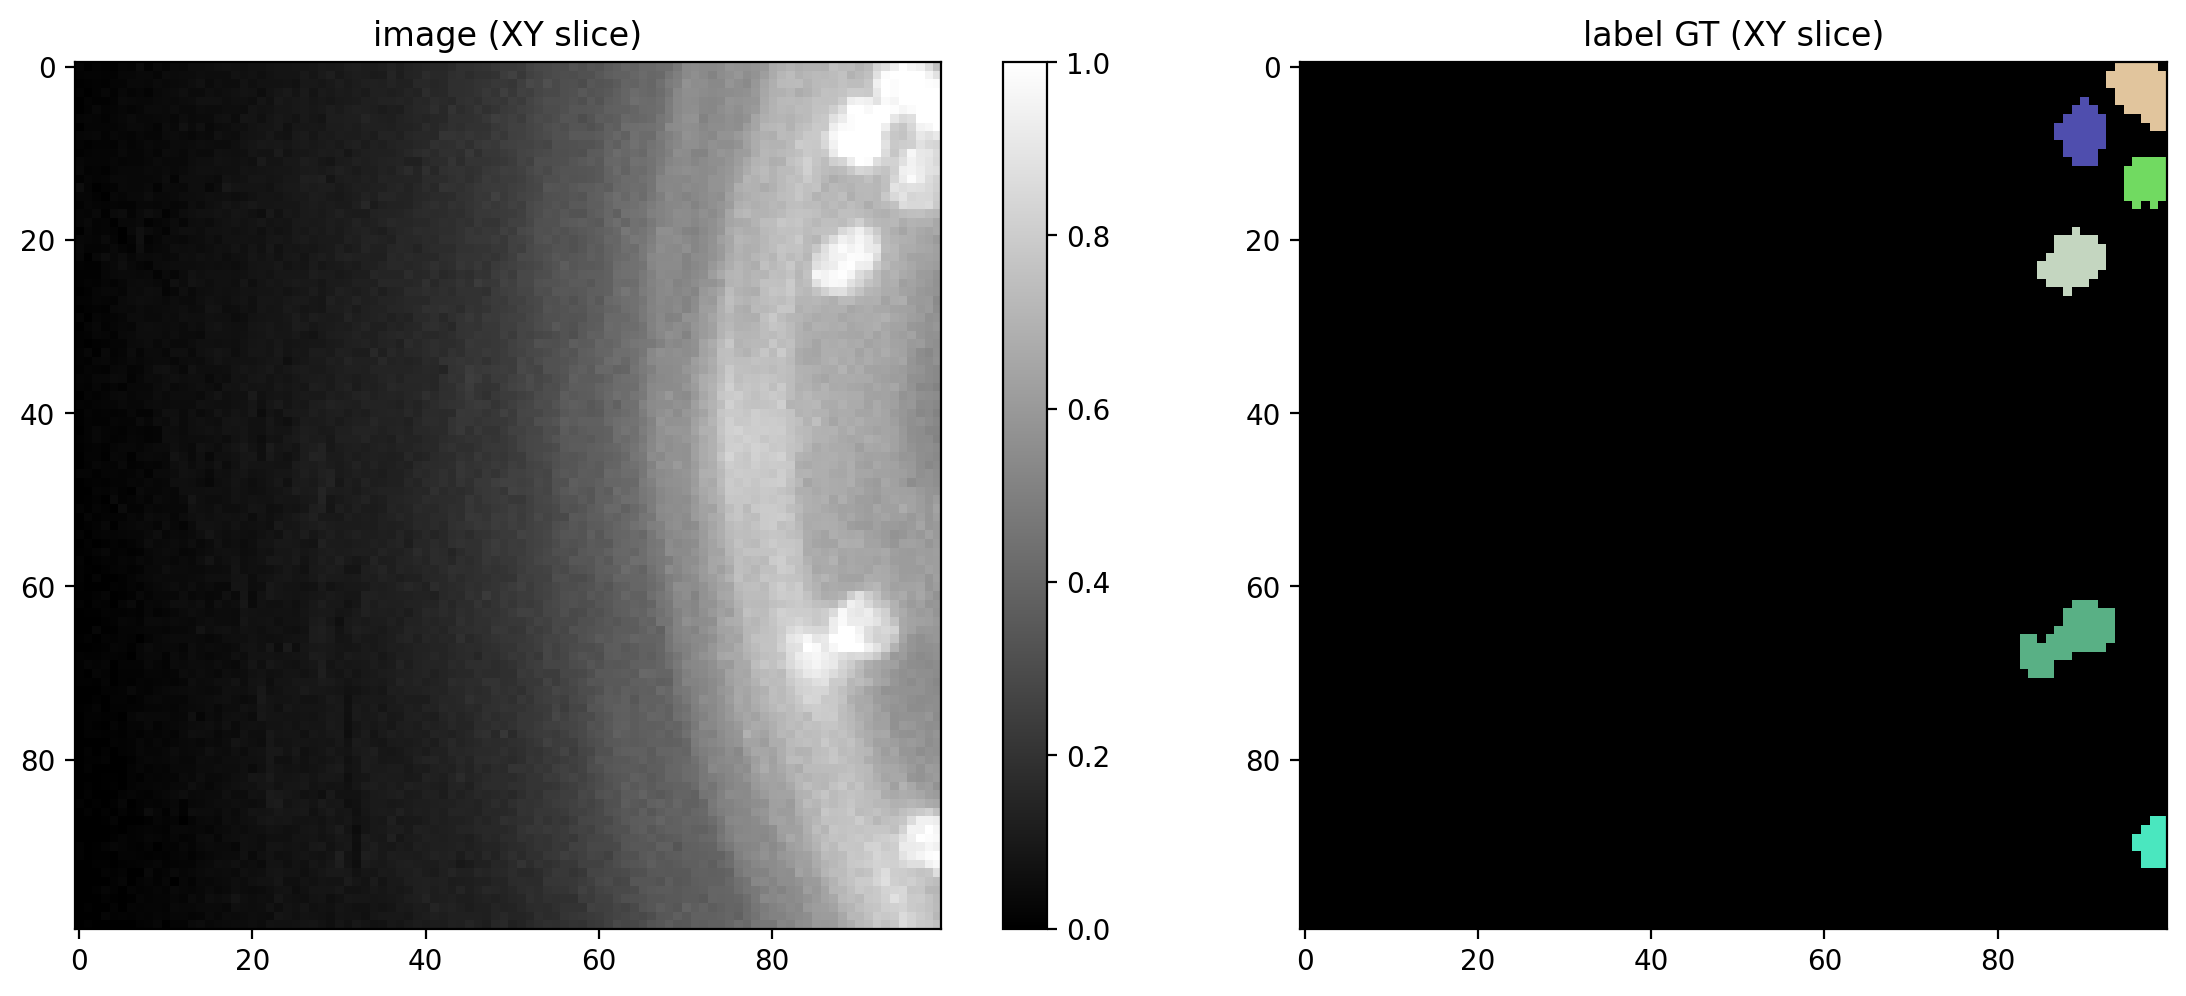

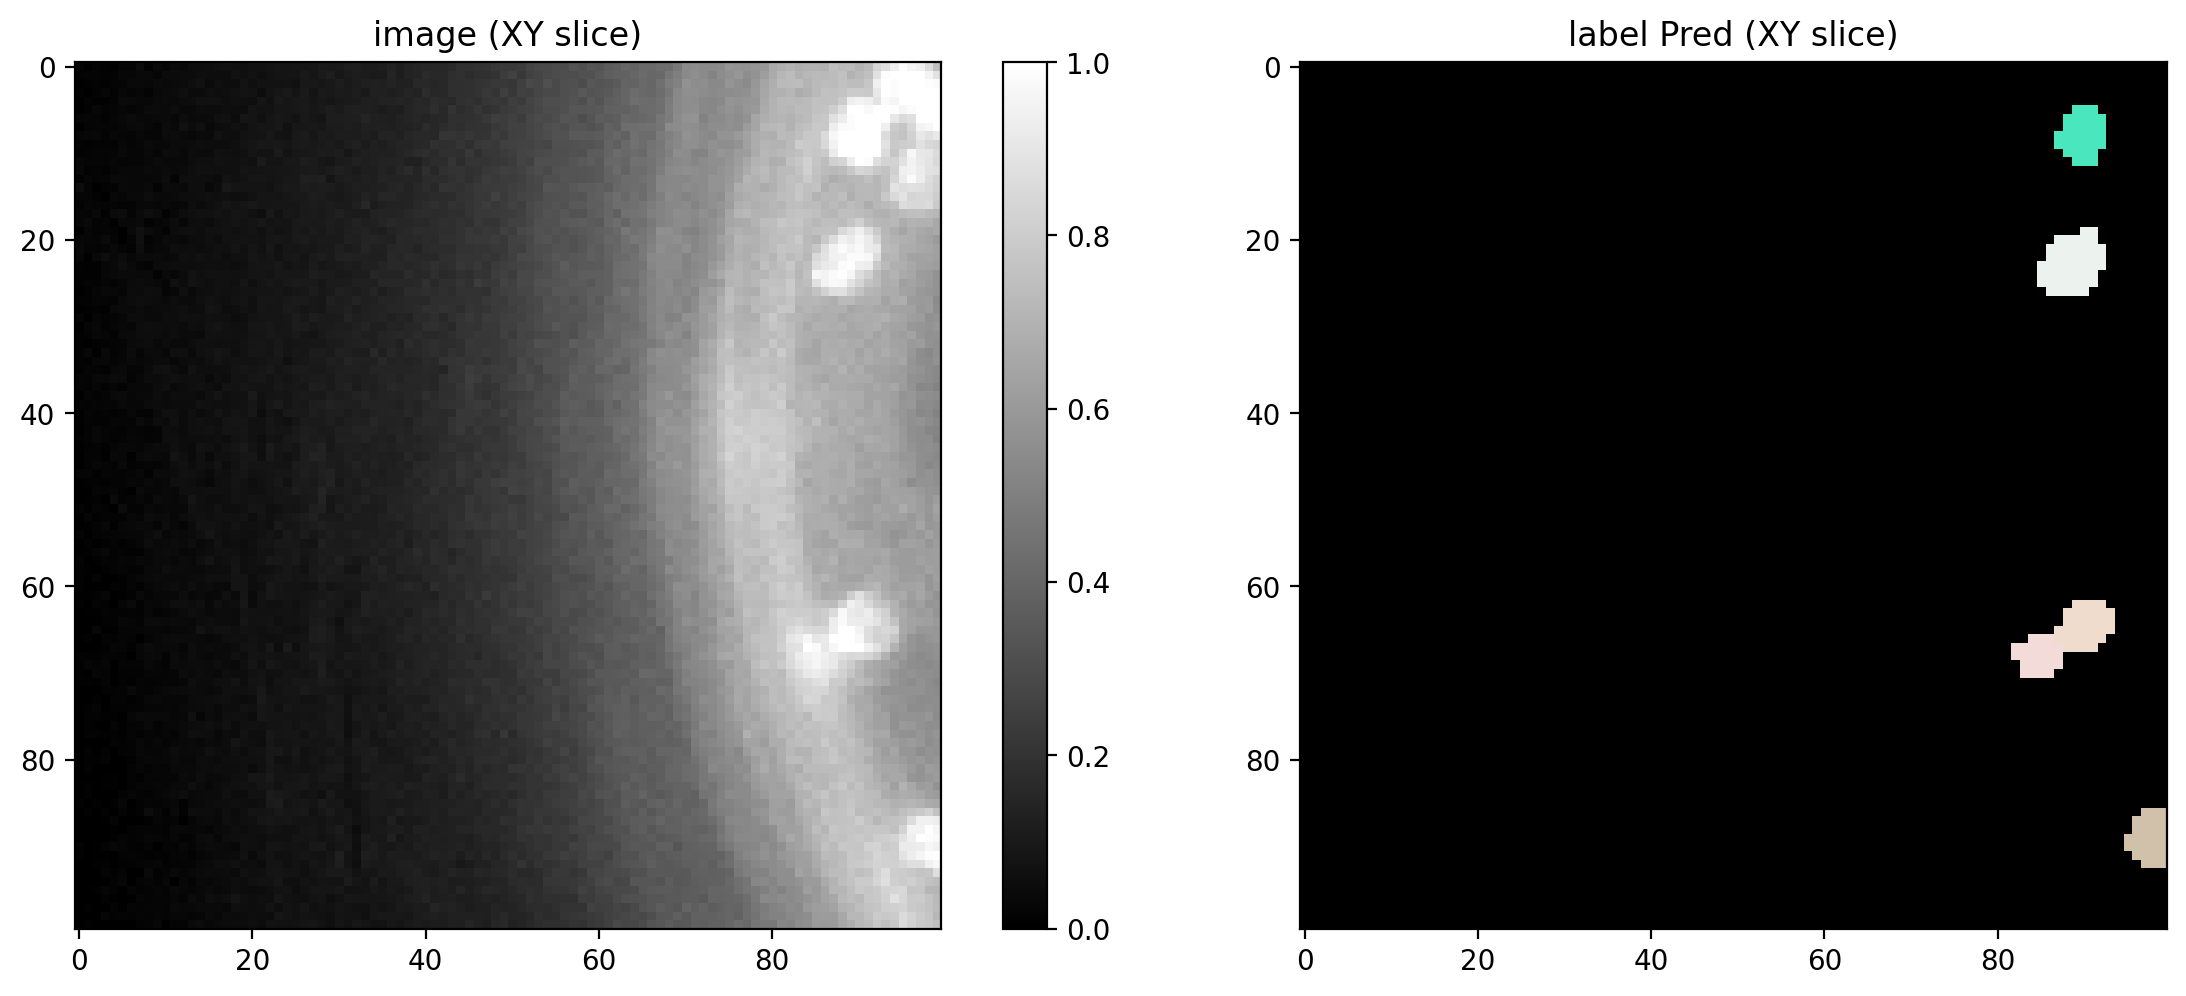

In [22]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT (XY slice)")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred (XY slice)")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [23]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 79.00it/s]


Example: Print all available matching statistics for $\tau=0.7$

In [24]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=27, tp=4, fn=54, precision=0.12903225806451613, recall=0.06896551724137931, accuracy=0.047058823529411764, f1=0.0898876404494382, n_true=58, n_pred=31, mean_true_score=0.05035864998554361, mean_matched_score=0.7302004247903824, panoptic_quality=0.06563599323958494, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

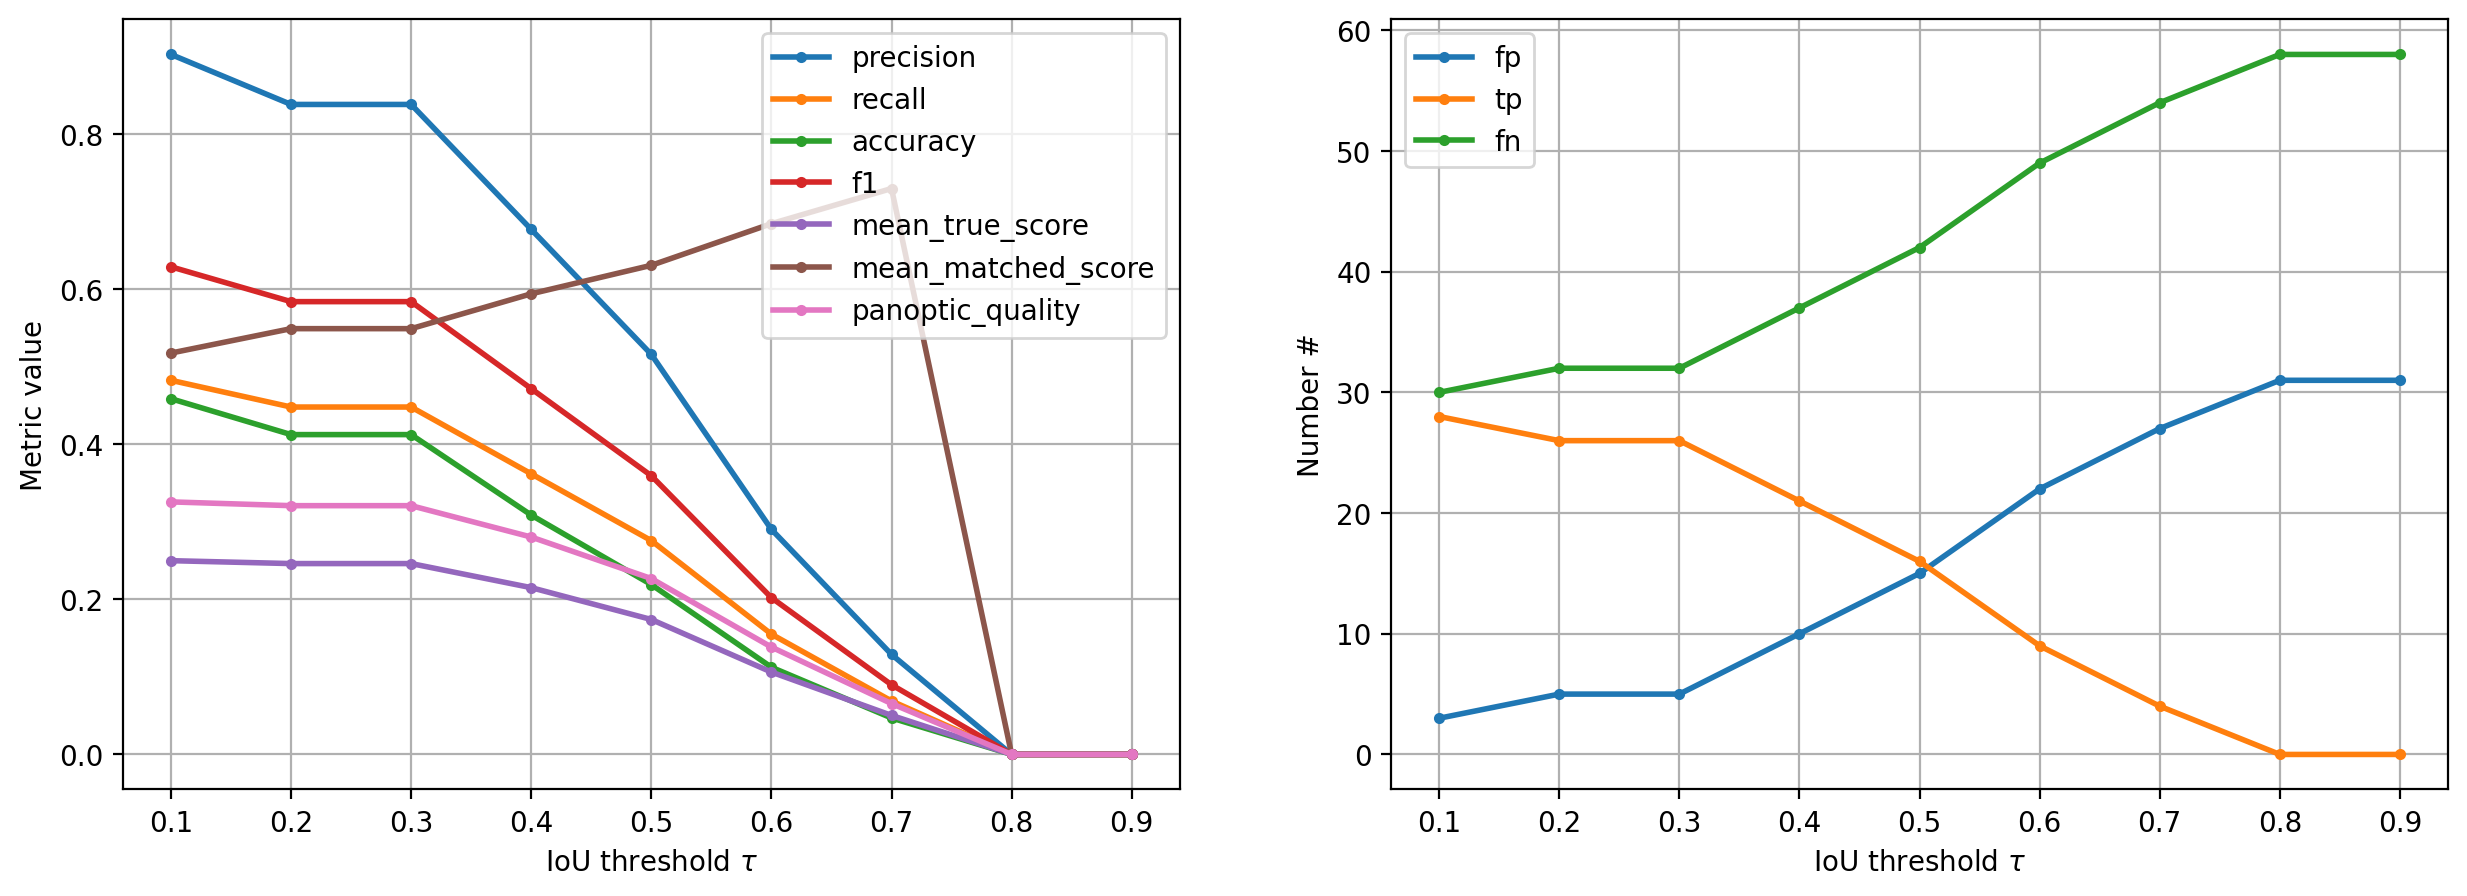

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();